In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import xgboost as xgb

sns.set()
sns.set_theme(context='notebook', style='darkgrid', palette='pastel', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('case1Data.txt')
df.head()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,90.685036,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,-4.994792,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H


### Feature variables (independent variables)

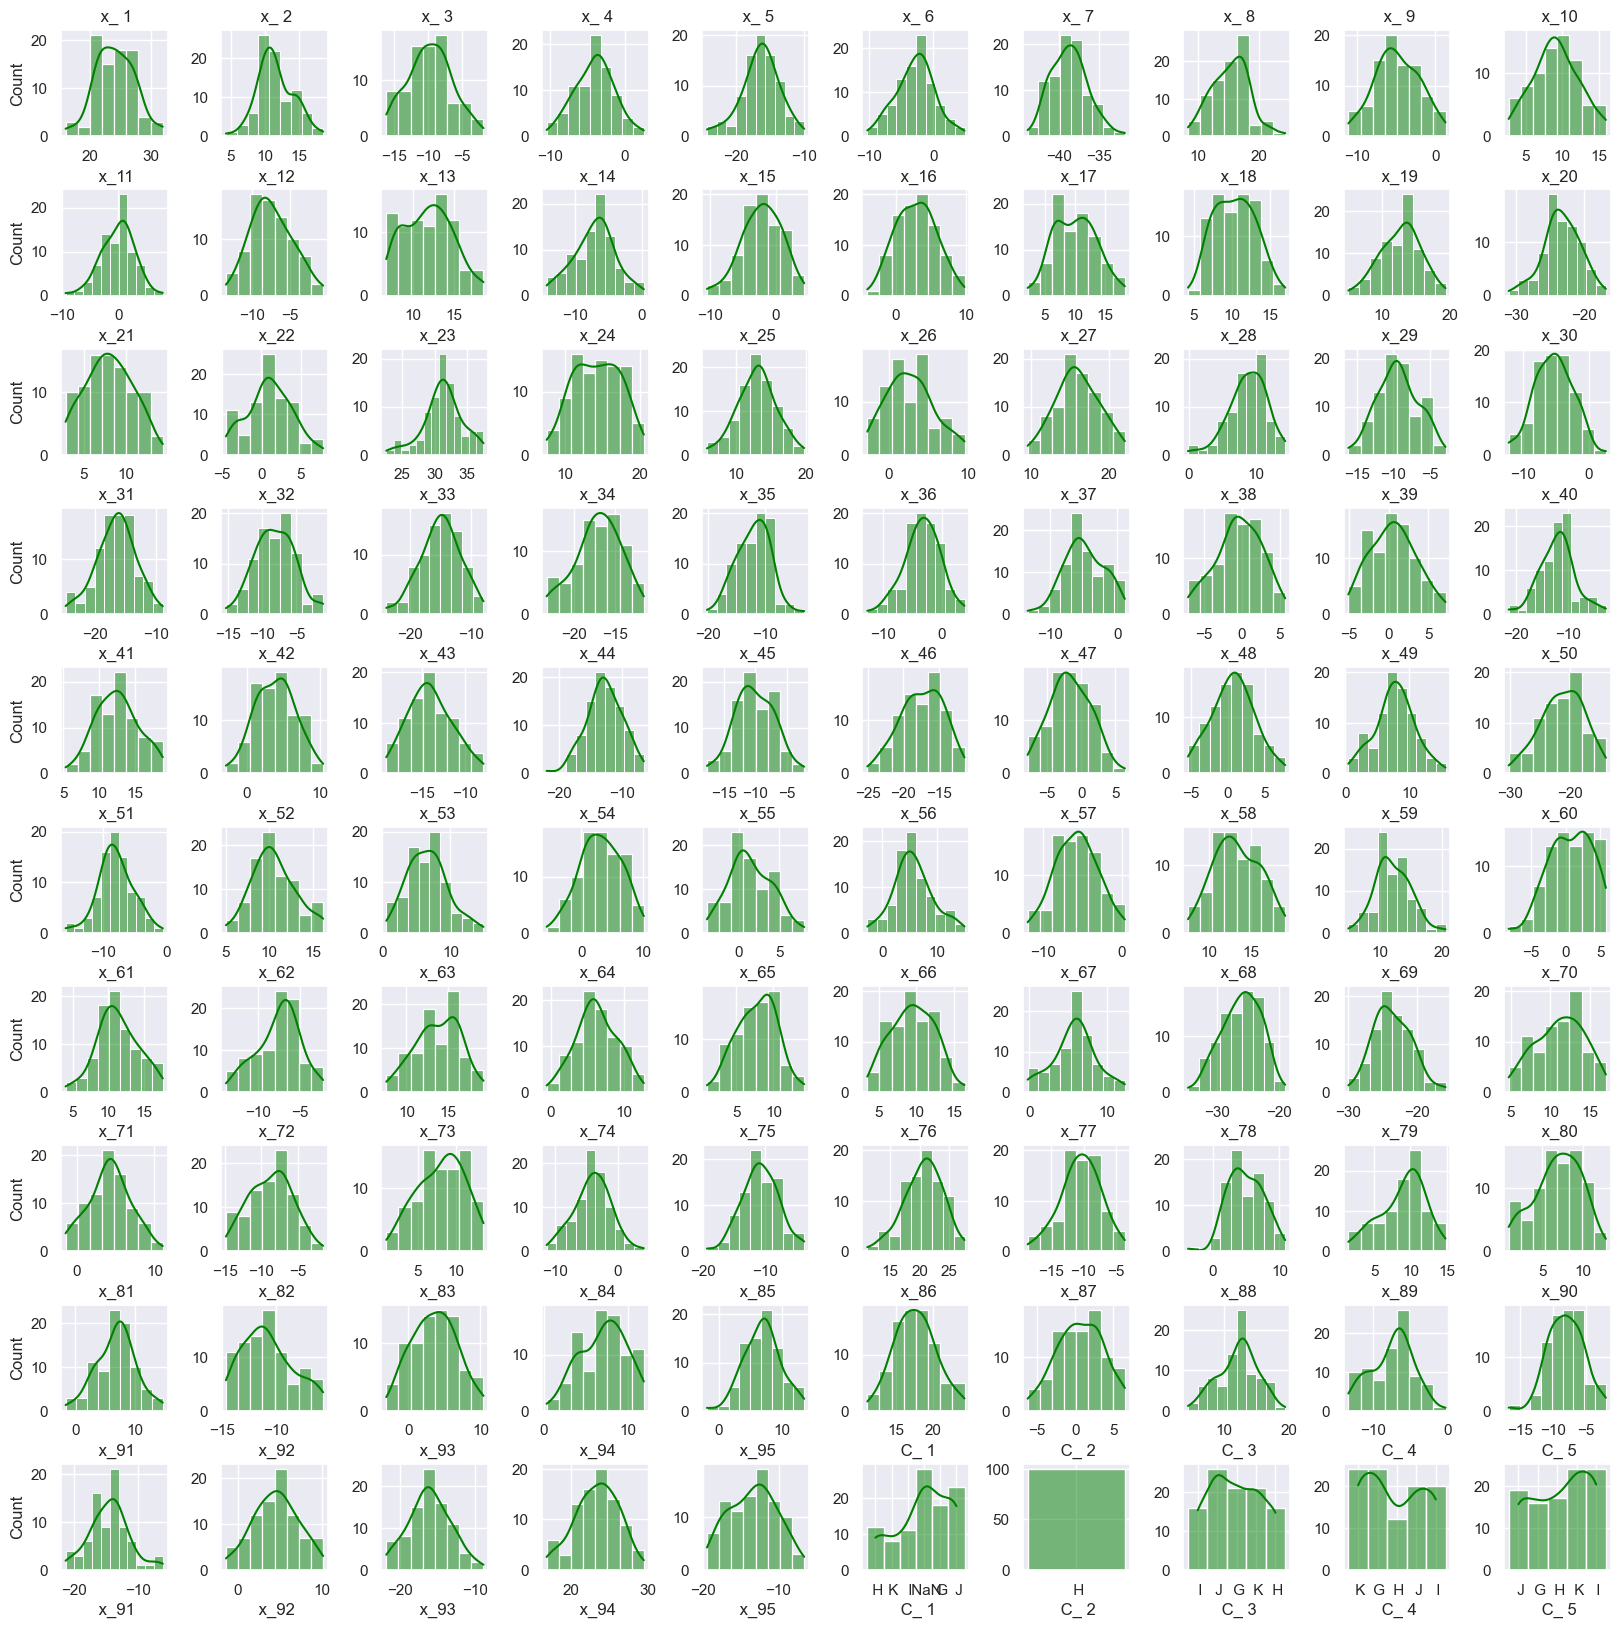

In [3]:
# Cast numerical values to floats
df.iloc[:, :-5] = df.iloc[:, :-5].astype(float)

y = df['y']
X = df.drop(columns=['y'])

fig, ax = plt.subplots(10, 10, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(10):
    for j in range(10):
        sns.histplot(X.iloc[:, i*10+j], ax=ax[i, j], kde=True, color="green")
        ax[i, j].set_title(X.columns[i*10+j])
        if j != 0:
            ax[i, j].set_ylabel('')
        if i != 9:
            ax[i, j].set_xlabel('')

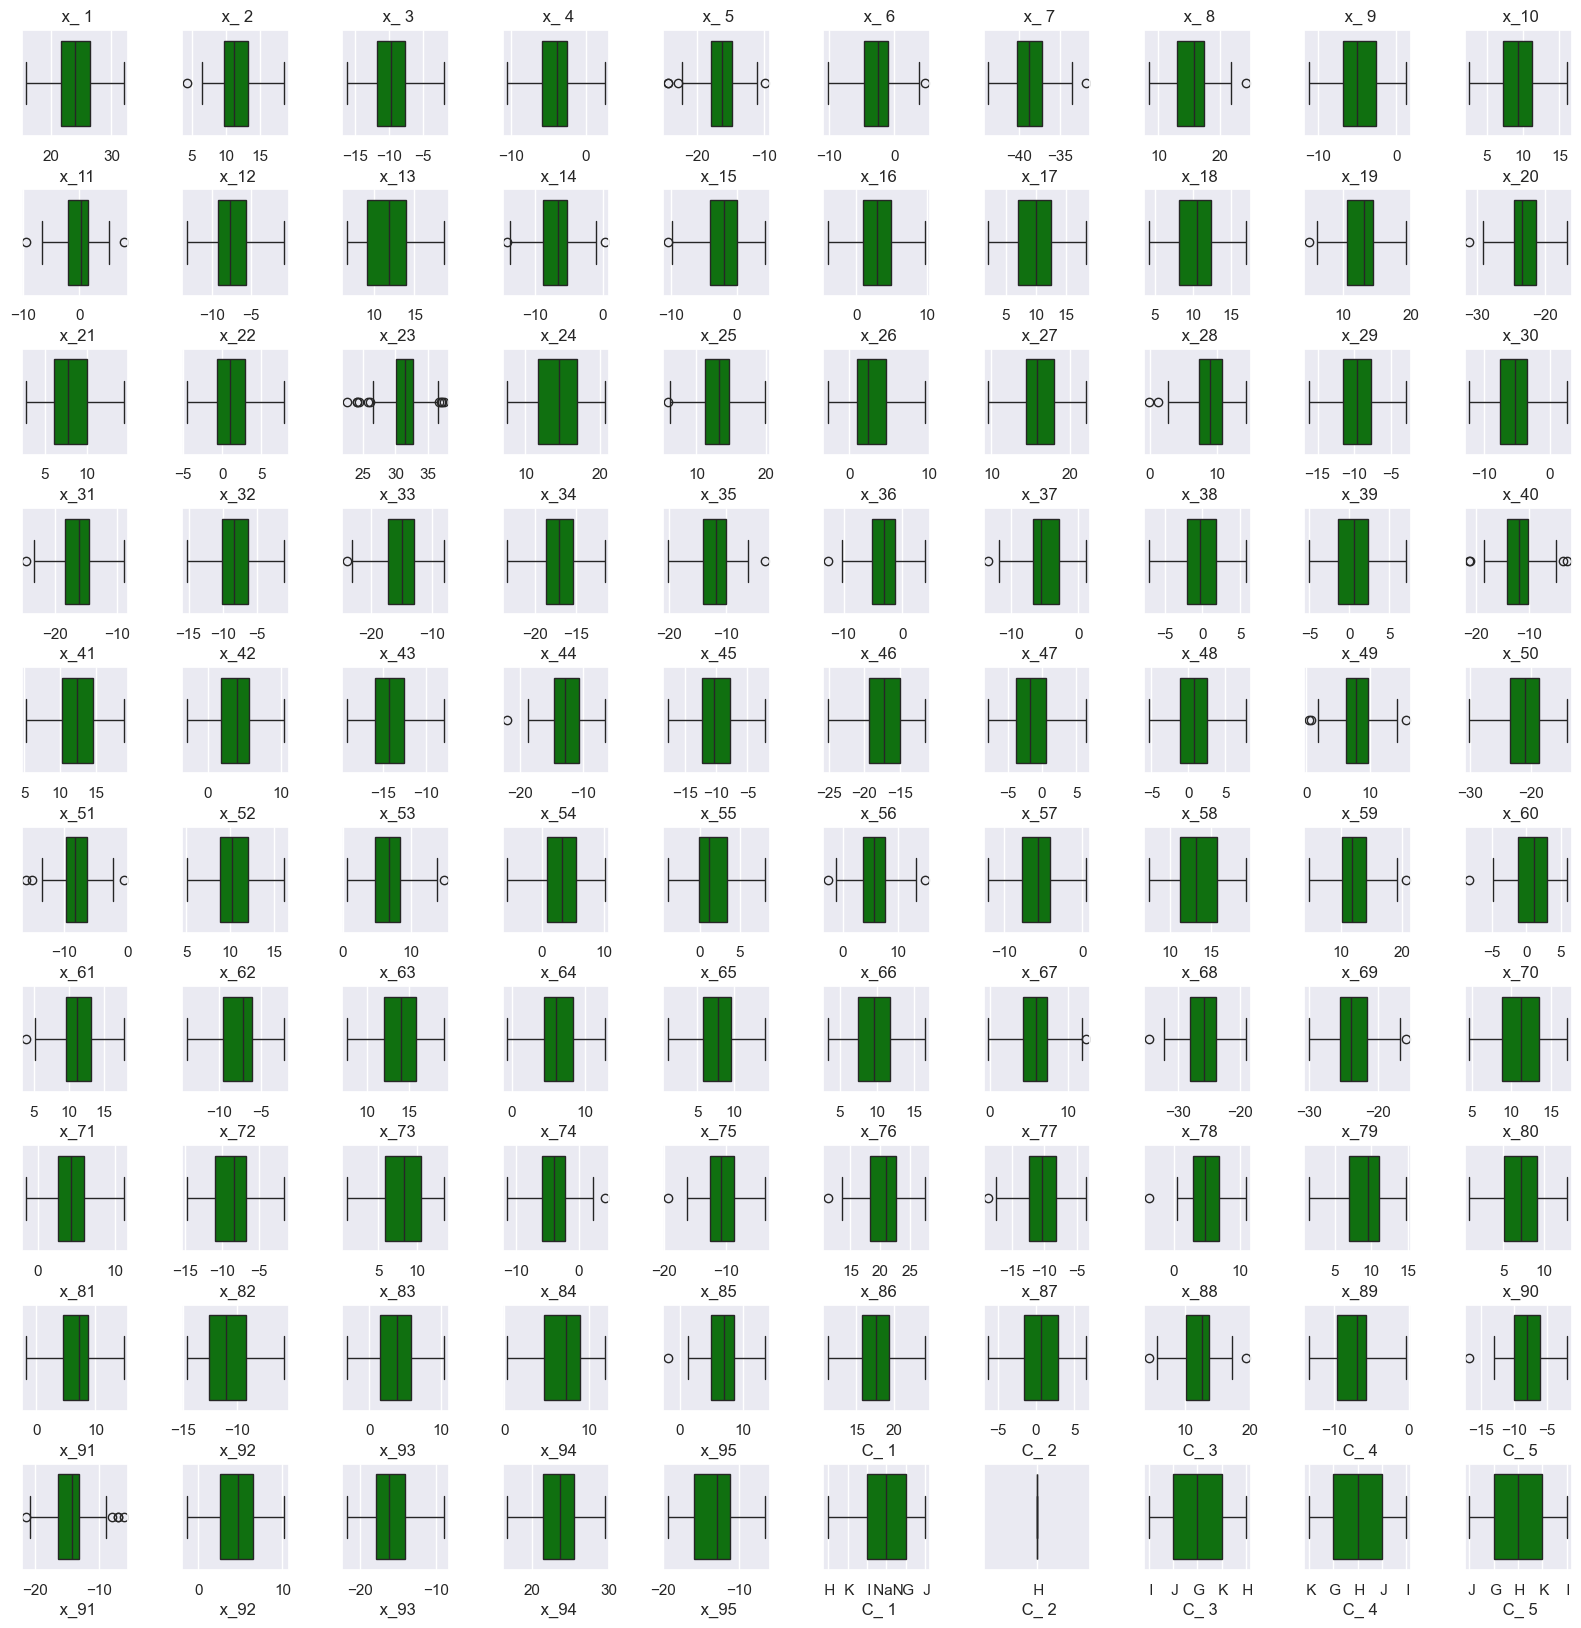

In [4]:
# Boxplots of the independent variables
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(10):
    for j in range(10):
        sns.boxplot(x=X.iloc[:, i*10+j], ax=ax[i, j], color="green")
        ax[i, j].set_title(X.columns[i*10+j])
        if j != 0:
            ax[i, j].set_ylabel('')
        if i != 9:
            ax[i, j].set_xlabel('')

### Response variable (dependent variable)

Text(0.5, 1.0, 'Distribution of the dependent variable y')

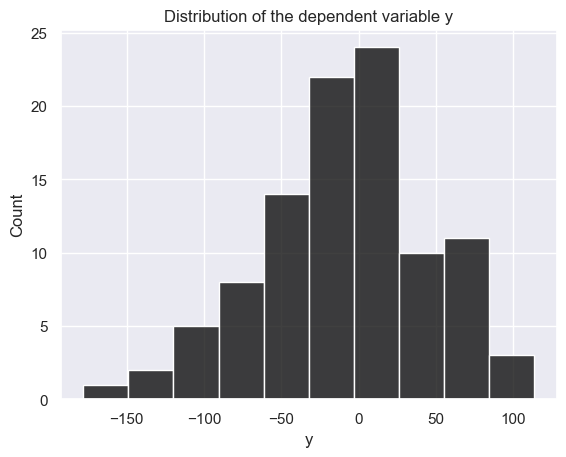

In [5]:
sns.histplot(df['y'], color="black")
plt.title("Distribution of the dependent variable y")

### Data Preprocessing

#### Missing Values

- The dataset contains a lot of missing values (1409)
- All the rows contain at least one missing value, so dropping rows with missing values is not an option
- We will consider simple imputing, looking at the distributions of the features, we see that there are no apparent outliers, so we will use the mean to impute the missing values (otherwise the outliers would have a big impact on the imputed values and median would be a better choice)
- For categorical features, we will use the mode to impute the missing values
- We will also consider using the KNN imputer, which is a more sophisticated method that takes into account the relationships between the features to impute the missing values
- We can impute under the assumption that they are missing at random, which is a reasonable assumption given that the missing values are spread across all the features

/var/folders/1g/nb69w5095276sxhrps7sndf80000gn/T/ipykernel_12560/1231648487.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace=r'^\s*NaN\s*$', value=np.nan, regex=True, inplace=True)


<Axes: title={'center': 'Total missing values: 1409'}, xlabel='Features'>

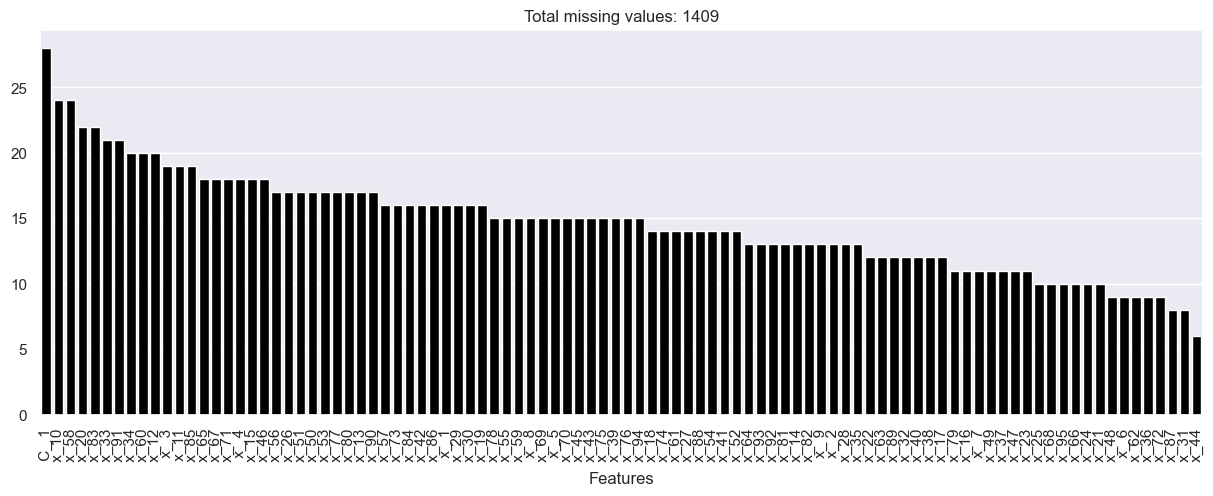

In [6]:
df.replace(to_replace=r'^\s*NaN\s*$', value=np.nan, regex=True, inplace=True)

# Check for missing values in the dataset
missing_values = df.isnull().sum()

missing_values_summary = {
    "Total Missing Values": missing_values.sum(),
    "Missing Values by Column": missing_values[missing_values > 0],
}

missing_values = missing_values[missing_values > 0]
missing_values.sort_values(ascending=False, inplace=True)

# Plot missing values
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.title(f'Total missing values: {missing_values_summary["Total Missing Values"]}')
plt.xlabel('Features')
sns.barplot(x=missing_values.index, y=missing_values.values, color='black')

In [7]:
missing_values

C_ 1    28
x_10    24
x_58    24
x_20    22
x_83    22
        ..
x_36     9
x_72     9
x_87     8
x_31     8
x_44     6
Length: 96, dtype: int64

In [24]:
# Impute missing values with the mean for numerical columns
df.iloc[:, :-5] = df.iloc[:, :-5].apply(lambda x: x.fillna(x.mean()), axis=0)

# Impute missing values with the mode for categorical columns
df.iloc[:, -5:] = df.iloc[:, -5:].apply(lambda x: x.fillna(x.mode()[0]), axis=0)

#### One hot encoding
- Since the dataset contains categorical features, and most of the models require numerical inputs, we will use one hot encoding to convert the categorical features into numerical features. Simpler encoding, e.g. encoding the categories with numbers, would not be appropriate, as it would imply an order between the categories, which we cannot assume for this dataset

- Since now we have $p > n$ (more features than samples), we no longer can use the standard linear regression, as it would not be able to find a unique solution.

In [25]:
# One hot encode categorical columns
df = pd.get_dummies(df, columns=[' C_ 1', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5'])
df = df.astype(float)
df.head()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,C_ 4_ G,C_ 4_ H,C_ 4_ I,C_ 4_ J,C_ 4_ K,C_ 5_ G,C_ 5_ H,C_ 5_ I,C_ 5_ J,C_ 5_ K
0,90.685036,24.152278,11.535373,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,15.323868,-2.442164,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-4.994792,25.400286,11.535373,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,15.323868,-7.341165,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Feature selection

- If features are correlated with each other it can cause multicollinearity, which can lead to unreliable estimates of the coefficients. We will use the correlation matrix to check for multicollinearity and deal with the features that are highly correlated with each other

- Additionally, we will check for the features that are most correlated with the response variable

In [26]:
X = df.drop('y', axis=1) 
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(95, 95)
Most correlated features


x_21  x_63    0.683229
x_63  x_21    0.683229
x_75  x_72    0.649540
x_72  x_75    0.649540
x_54  x_17    0.635274
x_17  x_54    0.635274
x_87  x_15    0.629723
x_15  x_87    0.629723
x_18  x_17    0.625075
x_17  x_18    0.625075
x_41  x_38    0.622097
x_38  x_41    0.622097
x_25  x_12    0.619169
x_12  x_25    0.619169
x_ 9  x_48    0.617830
dtype: float64

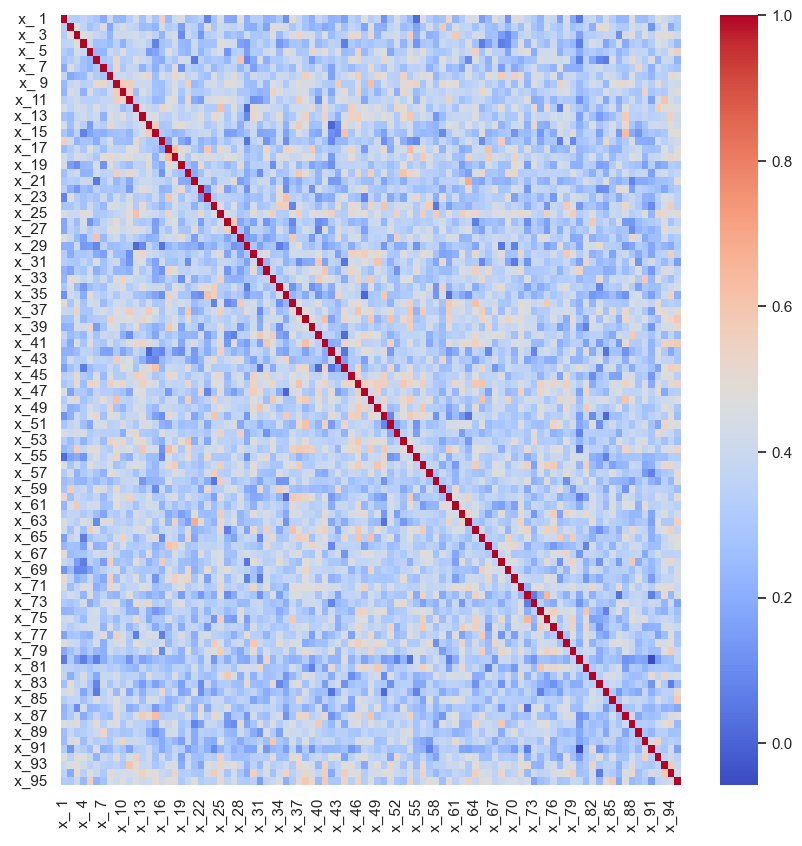

In [60]:
# Pairwise correlation matrix of the numerical features
correlation_matrix = X.iloc[:, :-21].corr()

# Plot the correlation matrix with no text on the cells
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Print 15 most correlated features
print("Most correlated numerical features")
correlation_matrix = correlation_matrix.abs().unstack().sort_values(ascending=False)
correlation_matrix = correlation_matrix[correlation_matrix < 1][:15]
correlation_matrix

/Users/lukyrasocha/miniconda3/envs/02582-compda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lukyrasocha/miniconda3/envs/02582-compda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: title={'center': 'Correlation with the target variable y'}, ylabel='None'>

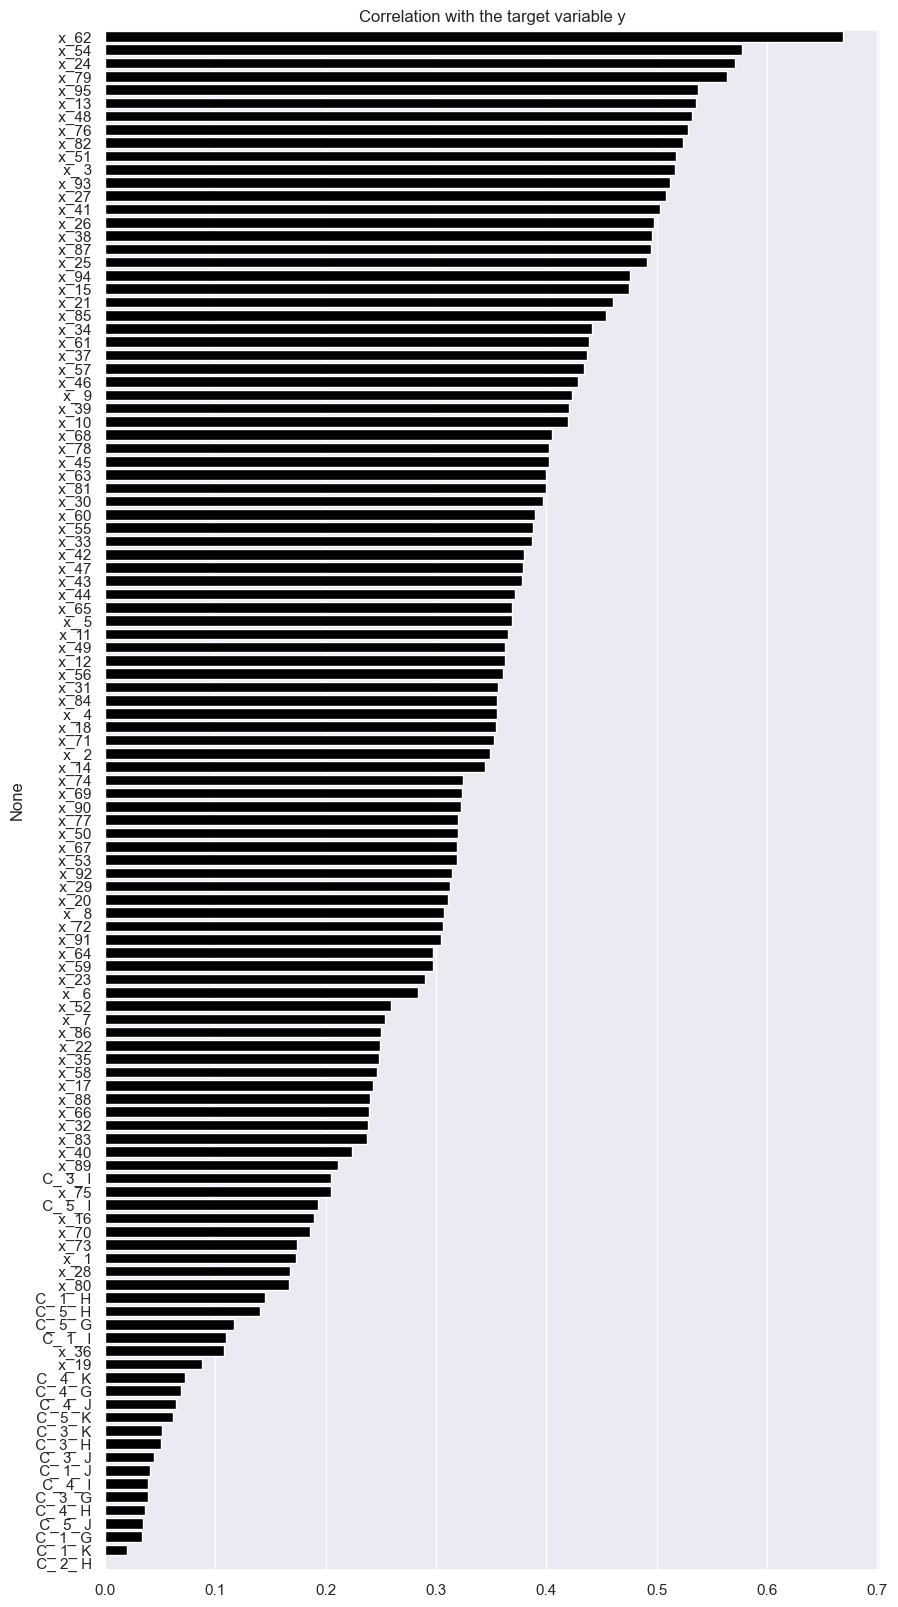

In [64]:
# Correlation with the target variable
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)

# Plot the correlation with the target variable
plt.figure(figsize=(10, 20))
plt.title("Correlation with the target variable y")
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, color='black')

### Chi-square test
- We do a chi-square test to check if there is a significant relationship between two categorical variables.
- p-value < 0.05: significant relationship (!!! TODO: WE NEED TO DO BONFERONI CORRECTION)
- C_2 has only value, thats why the p-value is 1

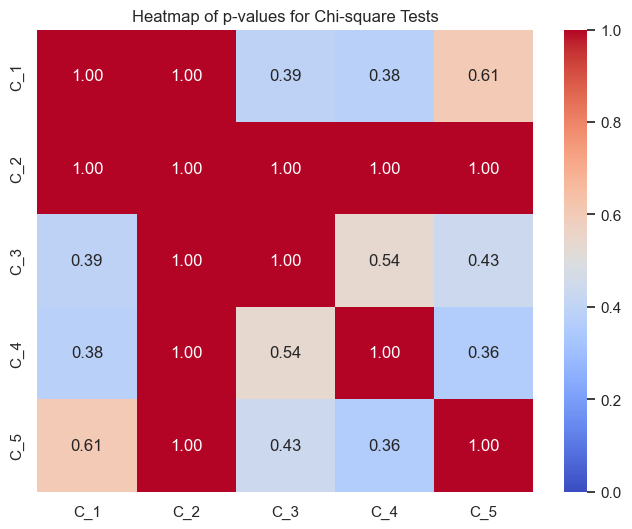

In [84]:
# Chi squared test for categorical features
from scipy.stats import chi2_contingency

original_data = pd.read_csv('case1Data.txt')
original_data = original_data.replace(to_replace=r'^\s*NaN\s*$', value=np.nan, regex=True)
categories = [' C_ 1', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5']

# Impute missing values with the mode for categorical columns
data = original_data[categories]
data = data.apply(lambda x: x.fillna(x.mode()[0]), axis=0)
data.head()

# Calculate the Chi-square test for each pair of categorical variables
chi_square_results = {}
for col1 in data.columns:
    for col2 in data.columns:
        if col1 != col2:
            # Create a contingency table
            contingency_table = pd.crosstab(data[col1], data[col2])
            # Perform the Chi-square test
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            chi_square_results[f'{col1} vs {col2}'] = {'Chi2': chi2, 'p-value': p, 'Degrees of Freedom': dof}

chi_square_results

columns = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5']
p_values_matrix = pd.DataFrame(index=columns, columns=columns)
p_values_matrix = p_values_matrix.astype(float)
p_values_matrix.fillna(1, inplace=True)

# Filling the matrix with p-values
for pair, result in chi_square_results.items():
    var1, var2 = pair.replace(' ', '').split('vs')
    p_values_matrix.loc[var1, var2] = result['p-value']
    p_values_matrix.loc[var2, var1] = result['p-value']

plt.figure(figsize=(8, 6))
sns.heatmap(p_values_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=0, vmax=1)
plt.title('Heatmap of p-values for Chi-square Tests')
plt.show()

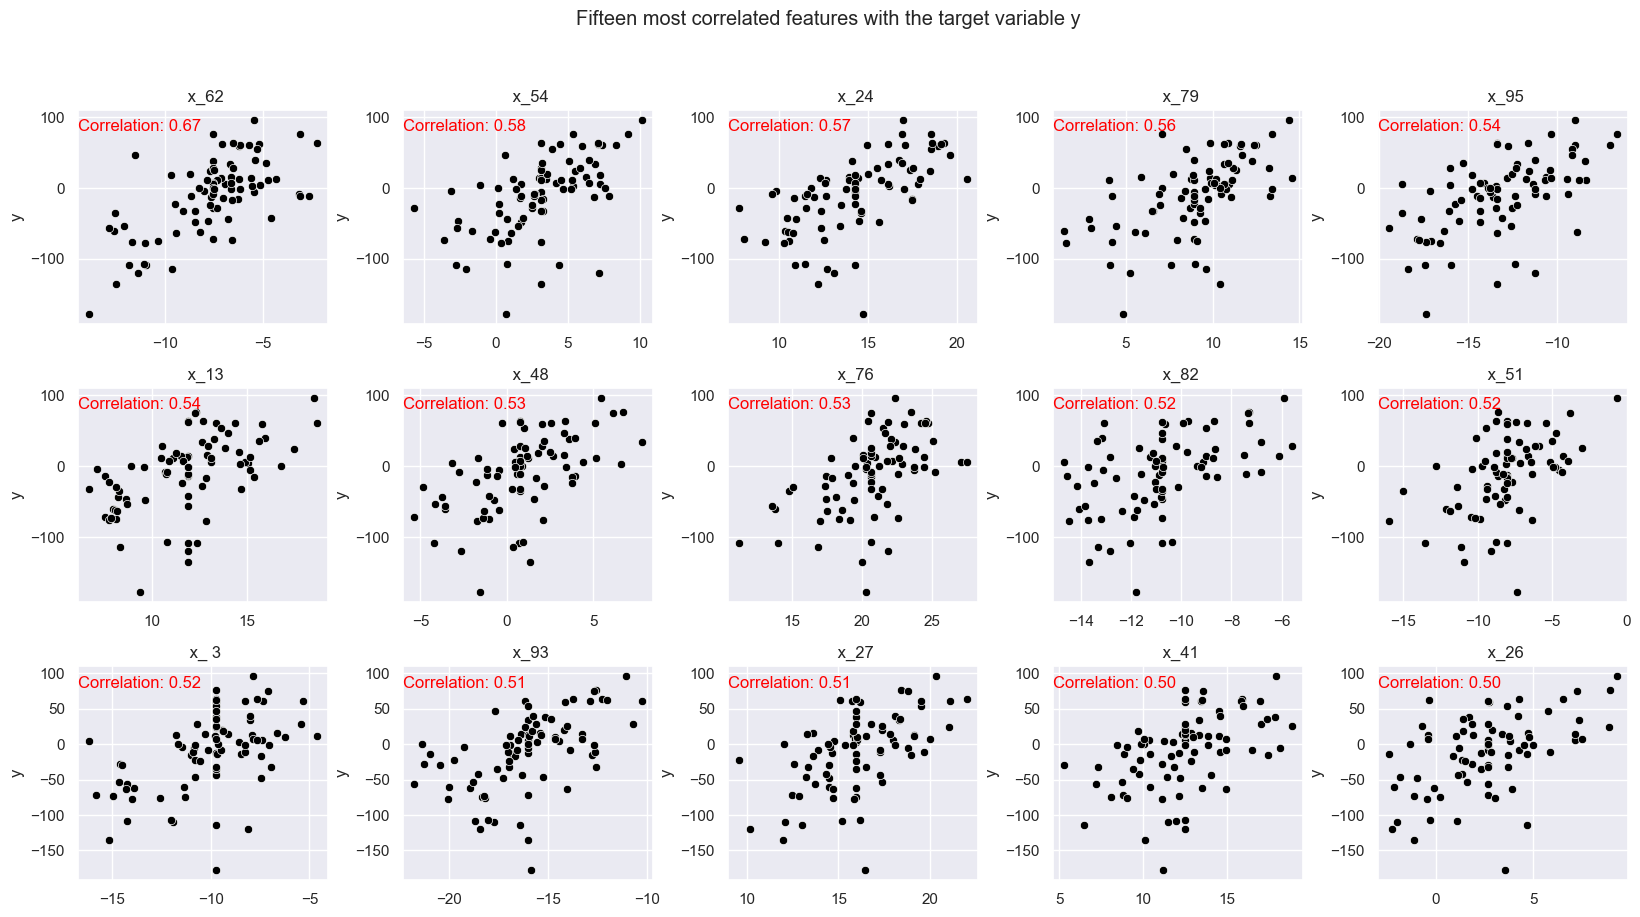

In [100]:
# Show the 15 most correlated features with the target variable as a 3x5 grid
fig, ax = plt.subplots(3, 5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Fifteen most correlated features with the target variable y')
for i in range(3):
    for j in range(5):
        sns.scatterplot(x=X_train[correlation_with_target.index[i*5+j]], y=y_train, ax=ax[i, j], color="black")
        ax[i, j].set_title(correlation_with_target.index[i*5+j])
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('y')
        # set text in the plot to show the correlation value
        ax[i, j].text(0.0, 0.9, f'Correlation: {correlation_with_target[correlation_with_target.index[i*5+j]]:.2f}', transform=ax[i, j].transAxes, color="red")

### Modelling

The correlations above didn't show any strong collinearity between the features, so we will use all the features for the modelling. However given that p>n we will use a regularized regression model, Lasso, which is a linear model that estimates sparse coefficients. It is useful in this case because it can reduce the number of features by setting some of the coefficients to zero, which can help to avoid overfitting.

Linear Regression

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 37.43679172196327
Mean Squared Error (MSE): 1823.1678520331927
Root Mean Squared Error (RMSE): 42.69856967198307
R-squared (R²): 0.4477440326311747


Random Forest Regression

In [14]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 30.235014361000005
Mean Squared Error (MSE): 1375.0605473629842
Root Mean Squared Error (RMSE): 37.08180884696679
R-squared (R²): 0.5834802638013903


Support Vector Regression (with gridsearch for hyperparameters)

In [15]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring=rmse_scorer)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)  # Negate because we set greater_is_better=False

Best Parameters: {'C': 0.1, 'epsilon': 0.5, 'kernel': 'linear'}
Best RMSE: 31.52952024332699


XgBoost (with gridsearch)

In [16]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best RMSE: 34.463899976983654
